# Installations

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 17.9 MB/s eta 0:00:00


# Mount Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# append paths
import sys
sys.path.append('/content/drive/MyDrive/2023_movie_recommender/')

# Imports

In [4]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

import pprint
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from models import RetrievalModel
from models import RankingModel

In [5]:
print(f'Tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'Tensorflow Recommenders version: {tfrs.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 2.11.0
keras version: 2.11.0
Tensorflow Recommenders version: v0.7.3
Numpy version: 1.21.6
Pandas version: 1.3.5


# Data preprocessing

In [6]:
# read data
dataset = '/content/drive/MyDrive/2023_movie_recommender/datasets/ml-latest-small'
movies = pd.read_csv(os.path.join(dataset, 'movies.csv'))
ratings = pd.read_csv(os.path.join(dataset, 'ratings.csv'))

In [7]:
# view movies dataframe
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# view ratings dataframe
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
# filter out rarely rated movies and rarely rating users
min_movie_ratings = 20

filter_movies = (ratings['movieId'].value_counts() > min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# get filtered data
mask = (ratings['movieId'].isin(filter_movies))
print(f'Before filtering, Ratings size: {ratings.shape}')
ratings = ratings[mask]
del filter_movies
print(f'After filtering, Ratings size: {ratings.shape}')
ratings.head()

Before filtering, Ratings size: (100836, 4)
After filtering, Ratings size: (66658, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
# convert timestamp to datetime
ratings['datetime'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings.head()

,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51


In [11]:
# extract month, day and hour
ratings['year'] = ratings.datetime.dt.year
ratings['month'] = ratings.datetime.dt.month
ratings['weekday'] = ratings['datetime'].apply(lambda x: x.weekday())
ratings['day'] = ratings.datetime.dt.day
ratings['hour'] = ratings.datetime.dt.hour
ratings.head()

,userId,movieId,rating,timestamp,datetime,year,month,weekday,day,hour
0,1,1,4.0,964982703,2000-07-30 18:45:03,2000,7,6,30,18
1,1,3,4.0,964981247,2000-07-30 18:20:47,2000,7,6,30,18
2,1,6,4.0,964982224,2000-07-30 18:37:04,2000,7,6,30,18
3,1,47,5.0,964983815,2000-07-30 19:03:35,2000,7,6,30,19
4,1,50,5.0,964982931,2000-07-30 18:48:51,2000,7,6,30,18


In [13]:
# remove pipes in genres
movies['genres'] = movies.genres.str.replace('(\|)', ' ')
movies.head()

<ipython-input-13-6a169495a1b4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['genres'] = movies.genres.str.replace('(\|)', ' ')


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
# left join ratings with movies
ratings = ratings.join(movies.set_index('movieId'), on='movieId', how='left')
ratings.head()

,userId,movieId,rating,timestamp,datetime,year,month,weekday,day,hour,title,genres
0,1,1,4.0,964982703,2000-07-30 18:45:03,2000,7,6,30,18,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,1,3,4.0,964981247,2000-07-30 18:20:47,2000,7,6,30,18,Grumpier Old Men (1995),Comedy Romance
2,1,6,4.0,964982224,2000-07-30 18:37:04,2000,7,6,30,18,Heat (1995),Action Crime Thriller
3,1,47,5.0,964983815,2000-07-30 19:03:35,2000,7,6,30,19,Seven (a.k.a. Se7en) (1995),Mystery Thriller
4,1,50,5.0,964982931,2000-07-30 18:48:51,2000,7,6,30,18,"Usual Suspects, The (1995)",Crime Mystery Thriller


In [15]:
# drop rows in ratings that don't have genres and years
print(f'Before droping: {ratings.shape}')
ratings = ratings[~ratings['genres'].isna()]
print(f'After droping: {ratings.shape}')

Before droping: (66658, 12)
After droping: (66658, 12)


In [16]:
# drop movies that don't have genres 
print(f'Before droping: {movies.shape}')
movies = movies[~movies['genres'].isna()]
print(f'After droping: {movies.shape}')
movies.describe()

Before droping: (9742, 3)
After droping: (9742, 3)


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [17]:
# drop unneeded columns
ratings.drop(['datetime'], axis=1, inplace=True)
ratings.head()

,userId,movieId,rating,timestamp,year,month,weekday,day,hour,title,genres
0,1,1,4.0,964982703,2000,7,6,30,18,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,1,3,4.0,964981247,2000,7,6,30,18,Grumpier Old Men (1995),Comedy Romance
2,1,6,4.0,964982224,2000,7,6,30,18,Heat (1995),Action Crime Thriller
3,1,47,5.0,964983815,2000,7,6,30,19,Seven (a.k.a. Se7en) (1995),Mystery Thriller
4,1,50,5.0,964982931,2000,7,6,30,18,"Usual Suspects, The (1995)",Crime Mystery Thriller


In [18]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66658 entries, 0 to 100834
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     66658 non-null  int64  
 1   movieId    66658 non-null  int64  
 2   rating     66658 non-null  float64
 3   timestamp  66658 non-null  int64  
 4   year       66658 non-null  int64  
 5   month      66658 non-null  int64  
 6   weekday    66658 non-null  int64  
 7   day        66658 non-null  int64  
 8   hour       66658 non-null  int64  
 9   title      66658 non-null  object 
 10  genres     66658 non-null  object 
dtypes: float64(1), int64(8), object(2)
memory usage: 6.1+ MB


In [19]:
# need to convert month, weekday, day, hour into float64
ratings['month'] = ratings['month'].astype(float)
ratings['weekday'] = ratings['weekday'].astype(float)
ratings['day'] = ratings['day'].astype(float)
ratings['hour'] = ratings['hour'].astype(float)

In [20]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66658 entries, 0 to 100834
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     66658 non-null  int64  
 1   movieId    66658 non-null  int64  
 2   rating     66658 non-null  float64
 3   timestamp  66658 non-null  int64  
 4   year       66658 non-null  int64  
 5   month      66658 non-null  float64
 6   weekday    66658 non-null  float64
 7   day        66658 non-null  float64
 8   hour       66658 non-null  float64
 9   title      66658 non-null  object 
 10  genres     66658 non-null  object 
dtypes: float64(5), int64(4), object(2)
memory usage: 6.1+ MB


In [21]:
# convert into Tensorflow Dataset
movies_tf = tf.data.Dataset.from_tensor_slices(dict(movies))
ratings_tf = tf.data.Dataset.from_tensor_slices(dict(ratings))

# test if the loading is correct
for x in ratings_tf.take(1).as_numpy_iterator():
    pprint.pprint(x)

for x in movies_tf.take(1).as_numpy_iterator():
    pprint.pprint(x)


{'day': 30.0,
 'genres': b'Adventure Animation Children Comedy Fantasy',
 'hour': 18.0,
 'month': 7.0,
 'movieId': 1,
 'rating': 4.0,
 'timestamp': 964982703,
 'title': b'Toy Story (1995)',
 'userId': 1,
 'weekday': 6.0,
 'year': 2000}
{'genres': b'Adventure Animation Children Comedy Fantasy',
 'movieId': 1,
 'title': b'Toy Story (1995)'}


In [22]:
# check unique movie titles and user ids
movies_tmp = movies_tf.map(lambda x: x['title'])
movie_titles = movies_tmp.batch(1_000)
user_ids = ratings_tf.batch(10_000).map(lambda x: x['userId'])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print(unique_movie_titles.shape)
print(unique_user_ids.shape)

(9737,)
(610,)


In [23]:
# split into train and test datasets
# total = 101_000
# ntrain = 81_000
# ntest = 20_000

total = 67_000
ntrain = 60_000
ntest = 7_000
tf.random.set_seed(42)
shuffled = ratings_tf.shuffle(total, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(ntrain)
test = shuffled.skip(ntrain).take(ntest)

cached_train = train.shuffle(ntrain).batch(2048)
cached_test = test.batch(4096).cache()

In [24]:
for x in cached_test.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'day': array([ 9.,  8., 12., ..., 24.,  5.,  2.]),
 'genres': array([b'Comedy Drama Romance', b'Action Adventure Comedy Romance',
       b'Children Comedy Fantasy', ..., b'Action Comedy Western',
       b'Adventure Fantasy Thriller IMAX', b'Adventure Children Fantasy'],
      dtype=object),
 'hour': array([ 8., 13., 14., ...,  2., 12., 15.]),
 'month': array([ 7.,  6.,  7., ..., 12.,  9.,  6.]),
 'movieId': array([ 1784,   552,  6936, ...,  1378, 40815,  4896]),
 'rating': array([4. , 2. , 4. , ..., 2.5, 3.5, 3.5]),
 'timestamp': array([1468051563,  834241987, 1215872303, ..., 1261623539, 1346847838,
       1054568482]),
 'title': array([b'As Good as It Gets (1997)', b'Three Musketeers, The (1993)',
       b'Elf (2003)', ..., b'Young Guns (1988)',
       b'Harry Potter and the Goblet of Fire (2005)',
       b"Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"],
      dtype=object),
 'userId': array([ 52, 314, 483, ...,  68, 249, 288]),
 'we

In [26]:
num_epochs = 200
timestamps = np.concatenate(list(ratings_tf.map(lambda x: x['timestamp']).batch(100)))
candidate_movies = movies_tf.map(lambda x: {
    'title': x['title'], 
    'genres': x['genres'],
    })


# Retrieval Model: discretized timestamp embedding + Sine-Cosine encoder + movie title embedding/encoding + movie genres embedding

In [29]:
# use buckets
emb_size = 16
time_encode_size = 16
layer_sizes = [128, 32]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'both'
use_gru = False
use_genres = False
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_retrieval = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/200
30/30 [==============================] - 16s 417ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 15117.6697 - regularization_loss: 0.0000e+00 - total_loss: 15117.6697
Epoch 2/200
30/30 [==============================] - 7s 206ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14484.2515 - regularization_loss: 0.0000e+00 - total_loss: 14484.2515
Epoch 3/200
30/30 [==============================] - 5s 165ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e

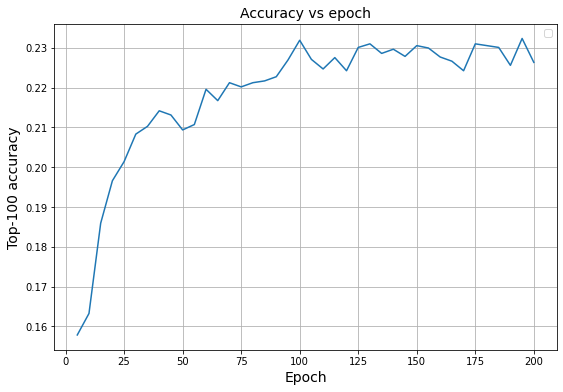

In [30]:
# plot and compare
num_validation_runs = len(history_retrieval.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_retrieval.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Retrieval Model Serving

In [37]:
# TFRS ScaNN layer to perform approximate retrieval
scann = tfrs.layers.factorized_top_k.ScaNN(
    num_reordering_candidates=500,
    num_leaves_to_search=30
)
movie_titles = candidate_movies.map(lambda x: x['title'])
scann.index_from_dataset(
  tf.data.Dataset.zip((movie_titles.batch(100), 
                       candidate_movies.batch(100).map(model.candidate_model)))
)

In [51]:
# example query
from datetime import datetime

year = 2018
month = 6
day = 23
hour = 20
dtime = datetime(year, month, day, hour)
example_timestamp = dtime.timestamp()
weekday = dtime.weekday()
query = {
    'userId': np.array([42]),
    'timestamp': np.array([example_timestamp]), 
    'year': np.array([float(year)]),
    'month': np.array([float(month)]),
    'weekday': np.array([float(weekday)]),
    'day': np.array([float(day)]),
    'hour': np.array([float(hour)])
}


In [53]:
# get recommendations
_, titles = scann(model.query_model(query), k=100)
print(f'Recommendations for user 42: {titles[0]}')

Recommendations for user 42: [b'Death Proof (2007)' b'Moneyball (2011)' b'1408 (2007)' b'Drive (2011)'
 b'Cabin in the Woods, The (2012)' b'Crazy, Stupid, Love. (2011)'
 b'Forgetting Sarah Marshall (2008)' b'Bridesmaids (2011)'
 b'Yes Man (2008)' b'Fighter, The (2010)' b'Super 8 (2011)'
 b'28 Weeks Later (2007)' b'Zack and Miri Make a Porno (2008)'
 b'Mission: Impossible - Ghost Protocol (2011)' b'Stardust (2007)'
 b'Notebook, The (2004)' b'Planet Terror (2007)'
 b'Silver Linings Playbook (2012)' b'Grindhouse (2007)'
 b'Island, The (2005)' b'True Grit (2010)'
 b'Darjeeling Limited, The (2007)' b'Step Brothers (2008)'
 b'Street Kings (2008)' b'Midnight in Paris (2011)' b'Town, The (2010)'
 b'Black Swan (2010)' b'Phone Booth (2002)'
 b'Girl with the Dragon Tattoo, The (2011)' b'Zodiac (2007)'
 b'Help, The (2011)' b'Capote (2005)' b'Ted (2012)'
 b'Burn After Reading (2008)' b'Meet the Fockers (2004)'
 b'Rise of the Planet of the Apes (2011)' b'Horrible Bosses (2011)'
 b'Moon (2009)' b'Wan

# Training of a Ranking Model

In [55]:
emb_size = 32
time_encode_size = 32
layer_sizes = [128, 32]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'both'
use_gru = False
use_genres = True
debug = False

ranking_model = RankingModel(timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_ranking = ranking_model.fit(
    cached_train,
    epochs=num_epochs,
    validation_data=cached_test,
    validation_freq=5,
    verbose=1,
    )

Epoch 1/200
30/30 [==============================] - 13s 242ms/step - root_mean_squared_error: 9.0087 - loss: 76.7511 - regularization_loss: 0.0000e+00 - total_loss: 76.7511
Epoch 2/200
30/30 [==============================] - 6s 187ms/step - root_mean_squared_error: 1.0050 - loss: 1.0022 - regularization_loss: 0.0000e+00 - total_loss: 1.0022
Epoch 3/200
30/30 [==============================] - 4s 114ms/step - root_mean_squared_error: 1.0030 - loss: 1.0078 - regularization_loss: 0.0000e+00 - total_loss: 1.0078
Epoch 4/200
30/30 [==============================] - 3s 85ms/step - root_mean_squared_error: 0.9992 - loss: 1.0008 - regularization_loss: 0.0000e+00 - total_loss: 1.0008
Epoch 5/200
30/30 [==============================] - 5s 140ms/step - root_mean_squared_error: 0.9890 - loss: 0.9792 - regularization_loss: 0.0000e+00 - total_loss: 0.9792 - val_root_mean_squared_error: 0.9858 - val_loss: 1.0008 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0008
Epoch 6/200
30/30 [====

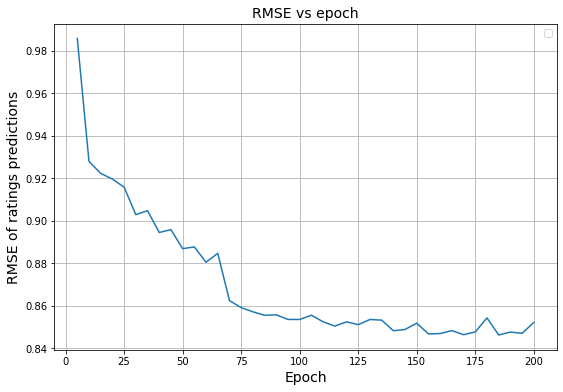

In [56]:
# plot and compare
num_validation_runs = len(history_ranking.history["val_root_mean_squared_error"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_ranking.history["val_root_mean_squared_error"])
plt.title("RMSE vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("RMSE of ratings predictions", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

In [77]:
mask = movies['title'] == 'Death Proof (2007)'
print(movies[mask].iloc[0,2])

Action Adventure Crime Horror Thriller


In [85]:
# get the predicted ratings for movies from the retrieval model
cand_titles = [t.decode('utf-8') for t in titles[0].numpy()]
pred_ratings = []

for t in cand_titles:
    mask = movies['title'] == t
    genres = movies[mask].iloc[0,2]
    query['title'] = np.array([t])
    query['genres'] = np.array([genres])
    pred_ratings.append(ranking_model(query).numpy()[0,0])

In [86]:
results = pd.DataFrame.from_dict({'movie_title': cand_titles, 'pred_ratings': pred_ratings})
results.head()

,movie_title,pred_ratings
0,Death Proof (2007),3.941679
1,Moneyball (2011),4.205220
2,1408 (2007),3.932944
3,Drive (2011),4.200487
4,"Cabin in the Woods, The (2012)",4.293130


In [88]:
# give the top 10 recommendations from 100 candidates
results.sort_values(by='pred_ratings', ascending=False).head(10)

,movie_title,pred_ratings
99,There Will Be Blood (2007),4.407803
76,In Bruges (2008),4.374376
48,"Girl with the Dragon Tattoo, The (Män som hata...",4.356168
30,"Help, The (2011)",4.353703
4,"Cabin in the Woods, The (2012)",4.293130
5,"Crazy, Stupid, Love. (2011)",4.289083
50,Easy A (2010),4.278011
94,3:10 to Yuma (2007),4.277296
16,Planet Terror (2007),4.269288
23,Street Kings (2008),4.264985
